# Acknowledgements

- Ulrich GOUE's Osic-Multiple-Quantile-Regression-Starter
    - Model that uses images can be found at: https://www.kaggle.com/miklgr500/linear-decay-based-on-resnet-cnn
- Michael Kazachok's Linear Decay (based on ResNet CNN)
    - Model that uses tabular data can be found at: https://www.kaggle.com/ulrich07/osic-multiple-quantile-regression-starter
- Replaced Michael's model with EfficientNets B0, B2, B4 and Inception

# Imports

In [1]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=508857e14c7b636c7557e8766bd789d890ee79eac96f3b1febd70e015f4613f5
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=a2b00baca290d95bbacbe7eca7005a5de5dd8cbb16fa06908024df499f21cee7
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [2]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 

# Linear Decay

In [5]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [6]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


## CNN for coeff prediction

In [7]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [8]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.unique():
            ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
            numb = [float(i[:-4]) for i in ldir]
            self.train_data[p] = [i for i in os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/') 
                                  if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15]
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [9]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
    model.load_weights('../input/osic-model-weights/' + weights)
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

# from tensorflow.keras.models import load_model
# model_name = "../input/fibrosis-models/best_model_v1_woDense_rmse.h5"
# model = load_model(model_name)
# models = [model]

Number of models: 1


In [10]:
from sklearn.model_selection import train_test_split 

tr_p, vl_p = train_test_split(P, 
                              shuffle=True, 
                              train_size= 0.8) 

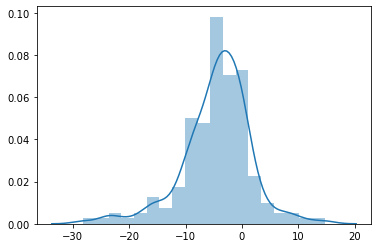

In [11]:
sns.distplot(list(A.values()));

In [12]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [13]:
subs = []
for model in models:
    metric = []
    for q in tqdm(range(1, 10)):
        m = []
        for p in vl_p:
            x = [] 
            tab = [] 

            if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
                continue

            ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
            for i in ldir:
                if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                    x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                    tab.append(get_tab(train.loc[train.Patient == p, :])) 
            if len(x) < 1:
                continue
            tab = np.array(tab) 

            x = np.expand_dims(x, axis=-1) 
            _a = model.predict([x, tab]) 
            a = np.quantile(_a, q / 10)

            percent_true = train.Percent.values[train.Patient == p]
            fvc_true = train.FVC.values[train.Patient == p]
            weeks_true = train.Weeks.values[train.Patient == p]

            fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
            percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
            m.append(score(fvc_true, fvc, percent))
        print(np.mean(m))
        metric.append(np.mean(m))

    q = (np.argmin(metric) + 1)/ 10

    sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)

6.7386115244278315
6.7386157849118185
6.738613409663092
6.73861177732523
6.738608976510854
6.73860117509752
6.738588805781414
6.738575478981084
6.73858318263184



## Averaging Predictions

In [14]:
N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)

In [15]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3092.863664,143.050520
1,ID00421637202311550012437_-12,2847.459621,190.504912
2,ID00422637202311677017371_-12,2002.654819,149.327313
3,ID00423637202312137826377_-12,3410.692459,195.951362
4,ID00426637202313170790466_-12,2971.430485,118.255453


In [16]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

In [17]:
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

In [18]:
q = (np.argmin(metric) + 1)/ 10
q

0.8

In [19]:
import math
def evaluation_model(df):
    df['sigma_clipped'] = df['Confidence'].apply(lambda x: max(x, 70))
    df['diff'] = abs(df['FVC'] - df['FVC_pred'])
    df['delta'] = df['diff'].apply(lambda x: min(x, 1000))
    df['score'] = -math.sqrt(2)*df['delta']/df['sigma_clipped'] - np.log(math.sqrt(2)*df['sigma_clipped'])
    score = df['score'].mean()
    return df, score

In [20]:
def prediction_model(model, df):
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {}
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    for p in tqdm(df.Patient.unique()):
        if p in BAD_ID:
            continue
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                tab.append(get_tab(df.loc[df.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = df.FVC.values[df.Patient == p] - a*df.Weeks.values[df.Patient == p]
        P_test[p] = df.Percent.values[df.Patient == p] 
        WEEK[p] = df.Weeks.values[df.Patient == p]
        
    return P_test, A_test, B_test, WEEK

In [21]:
import glob

P_train, A_train, B_train, WEEK_TRAIN = prediction_model(model, train)

In [22]:
for idx in train.index:
    w = train["Weeks"][idx]
    p = train["Patient"][idx]
    if p in A_train.keys():
        w = int(w) 

        fvc = A_train[p] * w + B_train[p]
        train.loc[idx, 'FVC_pred'] = fvc[0]
        train.loc[idx, 'Confidence'] = (
            P_train[p] - A_train[p] * abs(WEEK_TRAIN[p] - w) 
    ).mean()

In [23]:
train, score = evaluation_model(train)


In [24]:
print(score)

-6.732175126403196


# Osic-Multiple-Quantile-Regression

In [25]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [26]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [27]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())
#

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [28]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [29]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [30]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [31]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [32]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [33]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [34]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

In [35]:
chunk.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1535,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.615385,0.372400,0.179012,0.332421
1536,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.487179,0.320208,0.179012,0.427848
1537,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.615385,0.169948,0.179012,0.384612
1538,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,val,NaN,NaN,...,0.0,1,0,1,0,0,0.589744,0.423291,0.179012,0.405425
1539,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked,val,NaN,NaN,...,0.0,1,0,0,1,0,0.615385,0.354755,0.179012,0.345604


In [36]:
import math

C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = float(y_pred[:, 2]) - float(y_pred[:, 0])
    fvc_pred = float(y_pred[:, 1])
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(float(y_true[:, 0]) - float(fvc_pred))
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
#     1 - 0.5 exp(-1), 0.5, 0.5 exp(-1)
    
    qs = [0.5*math.exp(-1), 0.50, 1-0.5*math.exp(-1)]     # used to be [0.2,0.5,0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = float(y_true) - float(y_pred)
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [37]:
1-0.5*math.exp(-1)

0.8160602794142788

In [38]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [39]:
z

array([[1.        , 0.        , 1.        , ..., 0.23639327, 0.17901235,
        0.24145617],
       [1.        , 0.        , 1.        , ..., 0.21594131, 0.2345679 ,
        0.24145617],
       [1.        , 0.        , 1.        , ..., 0.18495963, 0.24691358,
        0.24145617],
       ...,
       [1.        , 0.        , 0.        , ..., 0.3422443 , 0.37037037,
        0.35475483],
       [1.        , 0.        , 0.        , ..., 0.35548363, 0.44444444,
        0.35475483],
       [1.        , 0.        , 0.        , ..., 0.31576566, 0.54320988,
        0.35475483]])

In [40]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [41]:
NFOLD = 5 # originally 5
kf = KFold(n_splits=NFOLD)

In [42]:
%%time
cnt = 0
EPOCHS = 860
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx].astype(float), y[tr_idx].astype(float), batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [39.896018981933594, 6.5575666427612305]
val [46.34127426147461, 6.733232021331787]
predict val...
predict test...
FOLD 2
train [37.25276565551758, 6.490952968597412]
val [52.693702697753906, 6.817661762237549]
predict val...
predict test...
FOLD 3
train [36.890140533447266, 6.475489616394043]
val [54.6210823059082, 6.7676005363464355]
predict val...
predict test...
FOLD 4
train [40.09593200683594, 6.56868839263916]
val [41.117034912109375, 6.593456745147705]
predict val...
predict test...
FOLD 5
train [36.249942779541016, 6.449378967285156]
val [50.89288330078125, 6.883365154266357]
predict val...
predict test...
CPU times: user 3min 42s, sys: 21.9 s, total: 4min 4s
Wall time: 3min 13s


In [43]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

146.7831850729082 254.25095373893018


In [44]:
pred.shape

(1535, 3)

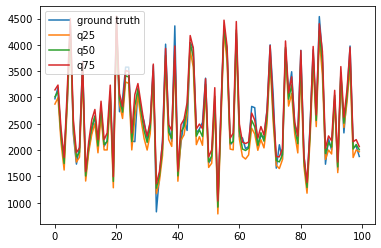

In [45]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [46]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

-34.069091796875 254.25095373893018 455.7880859375 0.9947882736156352


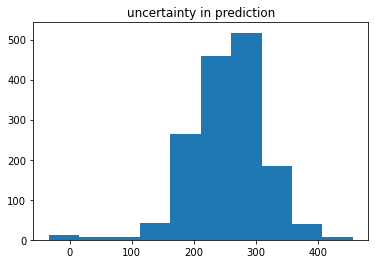

In [47]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [48]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [49]:
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2878.335144,252.314453
1541,ID00419637202311204720264_-11,3020,100.0,2875.830627,253.879822
1542,ID00419637202311204720264_-10,3020,100.0,2873.326172,255.445251
1543,ID00419637202311204720264_-9,3020,100.0,2870.821533,257.010559
1544,ID00419637202311204720264_-8,3020,100.0,2868.317017,258.575867
1545,ID00419637202311204720264_-7,3020,100.0,2865.812561,260.141235
1546,ID00419637202311204720264_-6,3020,100.0,2863.308044,261.706482
1547,ID00419637202311204720264_-5,3020,100.0,2860.803528,263.271729
1548,ID00419637202311204720264_-4,3020,100.0,2858.299011,264.837158
1549,ID00419637202311204720264_-3,3020,100.0,2855.794495,266.402344


In [50]:
sigma_opt

146.7831850729082

In [51]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),
                                                          'Confidence1']

In [52]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2878.335144,252.314453,2878.335144,252.314453
1541,ID00419637202311204720264_-11,2875.830627,253.879822,2875.830627,253.879822
1542,ID00419637202311204720264_-10,2873.326172,255.445251,2873.326172,255.445251
1543,ID00419637202311204720264_-9,2870.821533,257.010559,2870.821533,257.010559
1544,ID00419637202311204720264_-8,2868.317017,258.575867,2868.317017,258.575867


In [53]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2650.857753,329.360075,1969.412323,2575.056396,2696.908020,2833.176666,3217.415710
Confidence,730.0,316.751642,60.091906,195.054535,269.064270,317.329071,366.906441,432.700012
FVC1,730.0,2650.857753,329.360075,1969.412323,2575.056396,2696.908020,2833.176666,3217.415710
Confidence1,730.0,316.751642,60.091906,195.054535,269.064270,317.329071,366.906441,432.700012


In [54]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [55]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

In [56]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

# Ensemble (Simple Blend)

In [57]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [58]:
df = df1[['Patient_Week']].copy()
df['FVC'] = 0.25*df1['FVC'] + 0.75*df2['FVC']
df['Confidence'] = 0.26*df1['Confidence'] + 0.74*df2['Confidence']
df.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,2900.173109,225.070434
1,ID00419637202311204720264_-10,2926.186554,224.117671
2,ID00419637202311204720264_-11,2929.076891,224.011728
3,ID00419637202311204720264_-12,2931.967274,223.905830
4,ID00419637202311204720264_-2,2903.063538,224.964717


In [59]:
df.to_csv('submission.csv', index=False)